In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import poligrain as plg
import xarray as xr

# Special for plotting
from matplotlib.colors import LinearSegmentedColormap

# special for transformation
# "In house" functions
from mergeplg import merge

In [3]:
# Load processed data, resolution 5 minutes
ds_gauges = xr.open_dataset("./data/openmrg_municp_gauge.nc")
ds_cmls = xr.open_dataset("./data/openmrg_cml.nc")
ds_rad = xr.open_dataset("./data/openmrg_rad.nc")
ds_gauges_smhi = xr.open_dataset("./data/openmrg_smhi_gauge.nc")

# Fix error where lat/lon was set to variable
ds_rad = ds_rad.set_coords(["longitudes", "latitudes"])

# Fix naming errors
ds_gauges = ds_gauges.rename({"station_id": "id"})
ds_gauges_smhi = ds_gauges_smhi.rename({"station_id": "id"})

ds_rad = ds_rad.rename({"longitudes": "lon", "latitudes": "lat"})

In [4]:
# Threshold lower values
radar_zero = 0.01  # here in sum mm over 5 minutes
ds_rad["rainfall_amount"] = xr.where(
    ds_rad.rainfall_amount > radar_zero, ds_rad.rainfall_amount, 0
)

# Project data

In [5]:
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

In [6]:
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.lon, ds_gauges.lat, ref_str
)

ds_gauges_smhi.coords["x"], ds_gauges_smhi.coords["y"] = (
    plg.spatial.project_point_coordinates(
        ds_gauges_smhi.lon, ds_gauges_smhi.lat, ref_str
    )
)

In [7]:
# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

In [8]:
# Projected radar coords
ds_rad.coords["xs"], ds_rad.coords["ys"] = plg.spatial.project_point_coordinates(
    ds_rad.lon, ds_rad.lat, ref_str
)

# Adjust rainfall fields

In [9]:
rng = np.random.default_rng(seed=0)

# Do adjustment using additive IDW
additiveIDW = merge.MergeAdditiveIDW()

adjusted_rainfall = []
for time in ds_cmls.time.data:
    # Draw 100 random CMLs
    ind = np.arange(
        0, 100
    )  # rng.choice(np.arange(ds_cmls.cml_id.size), size=100, replace=False)
    ds_cmls_t = ds_cmls.isel(cml_id=ind)

    # Draw 5 random gauges
    ind = rng.choice(np.arange(ds_gauges.id.size), size=5, replace=False)
    ds_gauges_t = ds_gauges.isel(id=ind)

    # Update geometry of cmls and gauges
    additiveIDW.update(ds_rad, da_cml=ds_cmls_t, da_gauge=ds_gauges_t)

    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        additiveIDW.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls_t.sel(time=[time]).R,
            da_gauge=ds_gauges_t.sel(time=[time]).rainfall_amount,
        )
    )
ds_rad["rainfall_additiveIDW"] = xr.concat(adjusted_rainfall, dim="time")

In [10]:
rng = np.random.default_rng(seed=0)

# Do adjustment using additive Block-Kriging
additiveBlockKriging = merge.MergeAdditiveBlockKriging()

adjusted_rainfall = []
for time in ds_cmls.time.data:
    # Draw 100 random CMLs
    ind = rng.choice(np.arange(ds_cmls.cml_id.size), size=100, replace=False)
    ds_cmls_t = ds_cmls.isel(cml_id=ind)

    # Draw 5 random gauges
    ind = rng.choice(np.arange(ds_gauges.id.size), size=5, replace=False)
    ds_gauges_t = ds_gauges.isel(id=ind)

    # Update geometry of cmls and gauges
    additiveBlockKriging.update(ds_rad, da_cml=ds_cmls_t, da_gauge=ds_gauges_t)

    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        additiveBlockKriging.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls_t.sel(time=[time]).R,
            da_gauge=ds_gauges_t.sel(time=[time]).rainfall_amount,
        )
    )
ds_rad["rainfall_additiveBK"] = xr.concat(adjusted_rainfall, dim="time")

In [11]:
rng = np.random.default_rng(seed=0)

# Do adjustment using KED
KEDBlockKriging = merge.MergeBlockKrigingExternalDrift()

# Do adjustment
adjusted_rainfall = []
for time in ds_cmls.time.data:
    # Draw 100 random CMLs
    ind = rng.choice(np.arange(ds_cmls.cml_id.size), size=100, replace=False)
    ds_cmls_t = ds_cmls.isel(cml_id=ind)

    # Draw 5 random gauges
    ind = rng.choice(np.arange(ds_gauges.id.size), size=5, replace=False)
    ds_gauges_t = ds_gauges.isel(id=ind)

    # Update geometry of cmls and gauges
    KEDBlockKriging.update(ds_rad, da_cml=ds_cmls_t, da_gauge=ds_gauges_t)

    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        KEDBlockKriging.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls_t.sel(time=[time]).R,
            da_gauge=ds_gauges_t.sel(time=[time]).rainfall_amount,
        )
    )
ds_rad["rainfall_KED"] = xr.concat(adjusted_rainfall, dim="time")

In [12]:
cmap_colors = [
    (0, "white"),
    (radar_zero, "white"),
    (radar_zero, (0.5, 0.75, 0.25, 1.0)),
    (1, "blue"),
]  # white -> green-yellow mix -> dark blue
cmap_rain = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

/tmp/ipykernel_1849494/1316826363.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(
/tmp/ipykernel_1849494/1316826363.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[1].pcolormesh(
/tmp/ipykernel_1849494/1316826363.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[2].pcolormesh(
/tmp/ipykernel_1849494/1316826363.py:33: UserWarning: The input coor

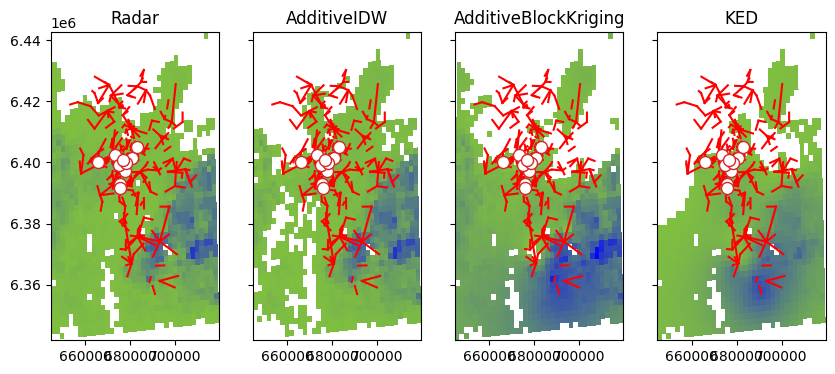

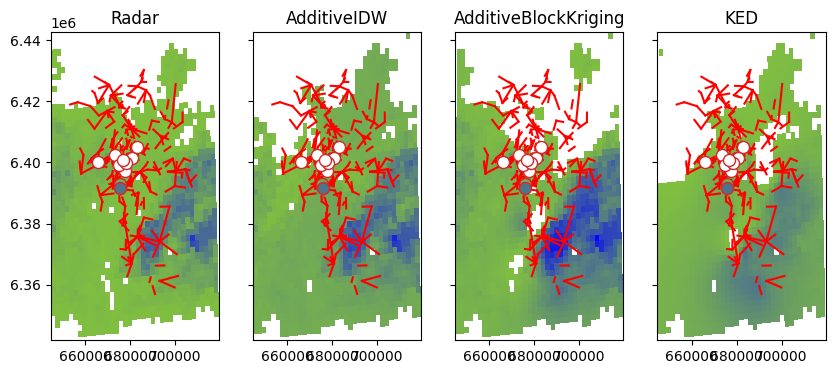

In [13]:
vmax = 1
for time in ds_cmls.time[0:2]:
    fig, ax = plt.subplots(1, 4, figsize=(10, 4), sharey=True)
    ax[0].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_amount.data,
        vmin=0,
        vmax=vmax,
        cmap=cmap_rain,
    )

    ax[1].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_additiveIDW.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )

    ax[2].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_additiveBK.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )

    ax[3].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_KED.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )

    ax[0].set_title("Radar")
    ax[1].set_title("AdditiveIDW")
    ax[2].set_title("AdditiveBlockKriging")
    ax[3].set_title("KED")

    for ax_i in range(len(ax)):
        for cml_id in ds_cmls.cml_id:
            ax[ax_i].plot(
                [
                    ds_cmls.sel(cml_id=cml_id).site_0_x,
                    ds_cmls.sel(cml_id=cml_id).site_1_x,
                ],
                [
                    ds_cmls.sel(cml_id=cml_id).site_0_y,
                    ds_cmls.sel(cml_id=cml_id).site_1_y,
                ],
                "red",
                zorder=1,
            )

    for ax_i in range(len(ax)):
        for station_id in ds_gauges.id:
            ax[ax_i].scatter(
                station_id.x,
                station_id.y,
                c=ds_gauges.sel(id=station_id, time=time).rainfall_amount,
                cmap=cmap_rain,
                edgecolors="C3",
                vmin=0,
                vmax=vmax,
                s=75,
                zorder=2,
            )
    plt.show()

# Compare to city rain gauges

In [14]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad,
    da_point_data=ds_gauges,
    nnear=1,
    stat="best",
)

radar_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

IDW_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_additiveIDW,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

BK_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_additiveBK,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

KED_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_KED,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

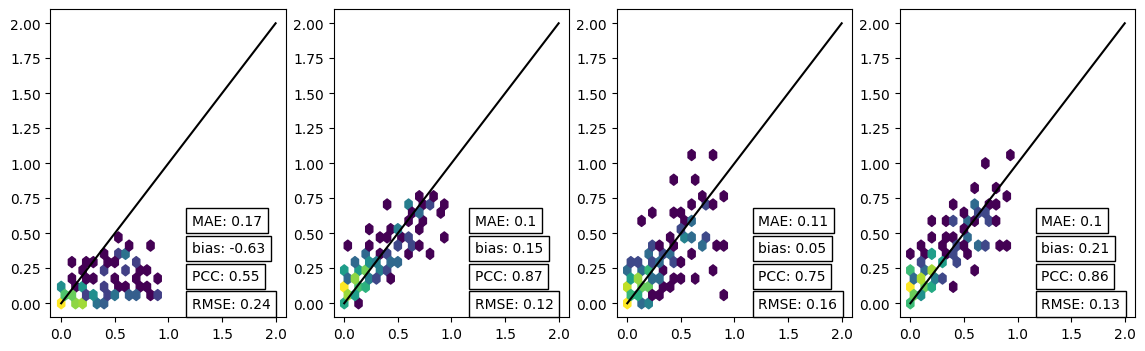

In [15]:
extent = [0, 2, 0, 2]
gridsize = 30

pred_models = [radar_at_points, IDW_at_points, BK_at_points, KED_at_points]
fig, ax = plt.subplots(1, len(pred_models), figsize=(14, 4))
ground = ds_gauges.rainfall_amount.data.ravel()
for i in range(len(pred_models)):
    tar = pred_models[i].data.ravel()

    keep = np.ones(ground.shape).astype(bool)
    keep = radar_at_points.data.ravel() > 0
    ax[i].hexbin(
        ground[keep], tar[keep], mincnt=1, extent=extent, gridsize=gridsize, bins="log"
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")

# Compare to SMHI rain gauge

In [16]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad,
    da_point_data=ds_gauges_smhi,
    nnear=1,
    stat="best",
)

radar_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges_smhi.rainfall_amount,  # Why do we require rainfal amount?
)

IDW_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_additiveIDW,
    da_point_data=ds_gauges_smhi.rainfall_amount,  # Why do we require rainfal amount?
)

BK_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_additiveBK,
    da_point_data=ds_gauges_smhi.rainfall_amount,  # Why do we require rainfal amount?
)

KED_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_KED,
    da_point_data=ds_gauges_smhi.rainfall_amount,  # Why do we require rainfal amount?
)

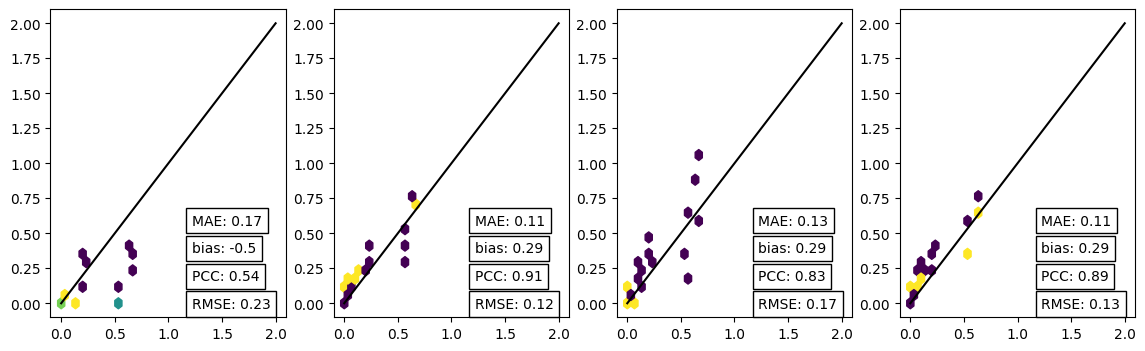

In [17]:
extent = [0, 2, 0, 2]
gridsize = 30

pred_models = [radar_at_points, IDW_at_points, BK_at_points, KED_at_points]
fig, ax = plt.subplots(1, len(pred_models), figsize=(14, 4))
ground = ds_gauges_smhi.rainfall_amount.data.ravel()
for i in range(len(pred_models)):
    tar = pred_models[i].data.ravel()

    keep = np.ones(ground.shape).astype(bool)
    keep = radar_at_points.data.ravel() > 0
    ax[i].hexbin(
        ground[keep], tar[keep], mincnt=1, extent=extent, gridsize=gridsize, bins="log"
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")